In [1]:
import pathlib
import os
os.environ['TF_PCC_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
import numpy as np

### Compilation Strategy

In [2]:
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


2023-04-11 13:08:42.438621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2884 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 980, pci bus id: 0000:02:00.0, compute capability: 5.2
2023-04-11 13:08:42.441389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3284 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 980, pci bus id: 0000:03:00.0, compute capability: 5.2


### Reading the data

In [3]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearnin/DATASETS/CatsVsDogs/cats_vs_dogs_small/')

In [4]:
tr_d = image_dataset_from_directory(
    w_dir / 'train',
    image_size=(180,180),
    batch_size=32
)

va_d = image_dataset_from_directory(
    w_dir / 'validation',
    image_size=(180,180),
    batch_size=32
)

te_d = image_dataset_from_directory(
    w_dir / 'test',
    image_size=(180,180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Augmentation

In [6]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
]
)

### Importin VGG16

In [5]:
conv_base = keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet'
)

conv_base.trainable = False

In [14]:
def get_model():
    inputs = keras.Input(shape=(180,180,3))
    
    x = layers.RandomFlip('horizontal')(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(0.2)(x)
    
    # Features straction
    x = keras.applications.vgg16.preprocess_input(x)
    
    conv_base = keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet'
    )

    conv_base.trainable = False
    
    x = conv_base(x)
    
    # my clasifier
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    return model

In [15]:
with strategy.scope():
    model = get_model()
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [16]:
callbacks = [ 
    keras.callbacks.ModelCheckpoint(
        filepath='strategy.keras',
        save_best_only=True,
        monitor='val_loss'
    ) 
]

history = model.fit(
    tr_d,
    epochs=52,
    validation_data=va_d,
    callbacks=callbacks
)

2023-04-11 13:49:20.637543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:49:20.638484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:49:20.642286: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
in

Epoch 1/52
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/tas

2023-04-11 13:49:25.049799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-11 13:49:25.184024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-11 13:49:27.223989: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-11 13:49:29.990925: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x266b68b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-11 13:49:29.990953: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 980, Compute Capability 5.2
2023-04-11 13:49:29.990960: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA GeFo

63/63 [==============================] - ETA: 0s - loss: 17.9938 - accuracy: 0.8995INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-04-11 13:49:36.971961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:49:36.973026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:49:36.974815: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
inp

63/63 [==============================] - 21s 184ms/step - loss: 17.9938 - accuracy: 0.8995 - val_loss: 7.9235 - val_accuracy: 0.9590
Epoch 2/52


2023-04-11 13:49:42.079297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:49:42.079697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 6.8659 - accuracy: 0.9486

2023-04-11 13:49:46.587245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:49:46.587686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:49:46.686208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 122ms/step - loss: 6.8110 - accuracy: 0.9490 - val_loss: 6.5334 - val_accuracy: 0.9670
Epoch 3/52


2023-04-11 13:49:49.860736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:49:49.861616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 4.8942 - accuracy: 0.9627

2023-04-11 13:49:54.429589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:49:54.430582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:49:54.568355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 124ms/step - loss: 4.8551 - accuracy: 0.9630 - val_loss: 4.5161 - val_accuracy: 0.9720
Epoch 4/52


2023-04-11 13:49:57.773033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:49:57.773830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 5.2754 - accuracy: 0.9551

2023-04-11 13:50:02.301782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:50:02.303047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:02.443651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 7s 117ms/step - loss: 5.5006 - accuracy: 0.9545 - val_loss: 4.7790 - val_accuracy: 0.9720
Epoch 5/52


2023-04-11 13:50:05.238174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:05.239204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 5.9003 - accuracy: 0.9551

2023-04-11 13:50:09.835458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:09.836457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:09.968379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 124ms/step - loss: 5.8531 - accuracy: 0.9555 - val_loss: 4.0373 - val_accuracy: 0.9780
Epoch 6/52


2023-04-11 13:50:13.178010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:13.178658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 4.2582 - accuracy: 0.9662

2023-04-11 13:50:17.719977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:50:17.720972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:17.861987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 124ms/step - loss: 4.3332 - accuracy: 0.9655 - val_loss: 3.2010 - val_accuracy: 0.9740
Epoch 7/52


2023-04-11 13:50:21.130347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:21.131201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 3.3374 - accuracy: 0.9748

2023-04-11 13:50:25.715527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:25.716517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:25.854253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 7s 118ms/step - loss: 3.3107 - accuracy: 0.9750 - val_loss: 3.9994 - val_accuracy: 0.9770
Epoch 8/52


2023-04-11 13:50:28.715596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:28.716614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 4.1944 - accuracy: 0.9662

2023-04-11 13:50:33.270077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:50:33.271152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:33.413266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 7s 118ms/step - loss: 4.1608 - accuracy: 0.9665 - val_loss: 3.8739 - val_accuracy: 0.9770
Epoch 9/52


2023-04-11 13:50:36.290720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:36.291697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 3.0856 - accuracy: 0.9743

2023-04-11 13:50:40.900393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:40.901350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:50:41.037895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 7s 118ms/step - loss: 3.1437 - accuracy: 0.9740 - val_loss: 6.2378 - val_accuracy: 0.9680
Epoch 10/52


2023-04-11 13:50:43.894652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:50:43.895689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 3.5438 - accuracy: 0.9693

2023-04-11 13:50:48.505046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:48.506131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:48.648394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 7s 119ms/step - loss: 3.5155 - accuracy: 0.9695 - val_loss: 7.1891 - val_accuracy: 0.9630
Epoch 11/52


2023-04-11 13:50:51.511507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:51.512556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 2.5917 - accuracy: 0.9758

2023-04-11 13:50:56.103945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:56.104920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:56.241808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 122ms/step - loss: 2.5892 - accuracy: 0.9755 - val_loss: 3.0823 - val_accuracy: 0.9780
Epoch 12/52


2023-04-11 13:50:59.330045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:50:59.330819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 1.7661 - accuracy: 0.9814

2023-04-11 13:51:03.859065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:03.859466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:03.967687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 123ms/step - loss: 1.7520 - accuracy: 0.9815 - val_loss: 3.0625 - val_accuracy: 0.9770
Epoch 13/52


2023-04-11 13:51:07.192084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:07.192938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 2.0572 - accuracy: 0.9778

2023-04-11 13:51:11.832312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:11.833356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:11.957547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 7s 119ms/step - loss: 2.0407 - accuracy: 0.9780 - val_loss: 4.6674 - val_accuracy: 0.9660
Epoch 14/52


2023-04-11 13:51:14.849568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:14.850571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 1.7194 - accuracy: 0.9808

2023-04-11 13:51:19.416103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:19.416489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:19.503021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 7s 117ms/step - loss: 1.7983 - accuracy: 0.9805 - val_loss: 3.7453 - val_accuracy: 0.9740
Epoch 15/52


2023-04-11 13:51:22.372204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:22.372652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 2.4940 - accuracy: 0.9793

2023-04-11 13:51:26.971673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:26.972074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:27.058844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 7s 118ms/step - loss: 2.5791 - accuracy: 0.9790 - val_loss: 4.1278 - val_accuracy: 0.9770
Epoch 16/52


2023-04-11 13:51:29.896861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:29.897881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 1.9001 - accuracy: 0.9758

2023-04-11 13:51:34.534089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:51:34.535062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:34.672819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 7s 119ms/step - loss: 1.9468 - accuracy: 0.9750 - val_loss: 3.5838 - val_accuracy: 0.9810
Epoch 17/52


2023-04-11 13:51:37.547940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:37.548388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 1.5419 - accuracy: 0.9849

2023-04-11 13:51:42.220749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:42.221797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:42.357484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 120ms/step - loss: 1.5613 - accuracy: 0.9845 - val_loss: 3.6823 - val_accuracy: 0.9770
Epoch 18/52


2023-04-11 13:51:45.242948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:51:45.243428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 1.6439 - accuracy: 0.9783

2023-04-11 13:51:49.819269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:51:49.819659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:51:49.910849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000

63/63 [==============================] - 8s 126ms/step - loss: 1.6611 - accuracy: 0.9780 - val_loss: 2.4422 - val_accuracy: 0.9830
Epoch 19/52


2023-04-11 13:51:53.247591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:53.248041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.9869

2023-04-11 13:51:57.924647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:57.925657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:51:58.068060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 121ms/step - loss: 0.7438 - accuracy: 0.9865 - val_loss: 3.3306 - val_accuracy: 0.9700
Epoch 20/52


2023-04-11 13:52:00.992057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:00.993117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 1.2960 - accuracy: 0.9783

2023-04-11 13:52:05.731665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:52:05.732668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:05.875605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 123ms/step - loss: 1.2857 - accuracy: 0.9785 - val_loss: 2.8868 - val_accuracy: 0.9800
Epoch 21/52


2023-04-11 13:52:08.875007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:08.876025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.9349 - accuracy: 0.9839

2023-04-11 13:52:13.622477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:52:13.623621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:13.762040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 123ms/step - loss: 1.0455 - accuracy: 0.9830 - val_loss: 2.9081 - val_accuracy: 0.9780
Epoch 22/52


2023-04-11 13:52:16.779752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:16.780272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.9535 - accuracy: 0.9869

2023-04-11 13:52:21.513557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:21.513952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:21.605392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 124ms/step - loss: 0.9459 - accuracy: 0.9870 - val_loss: 3.3730 - val_accuracy: 0.9750
Epoch 23/52


2023-04-11 13:52:24.712381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:52:24.712792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - ETA: 0s - loss: 1.0141 - accuracy: 0.9835

2023-04-11 13:52:29.454105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:29.455104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:29.594875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 127ms/step - loss: 1.0141 - accuracy: 0.9835 - val_loss: 4.2816 - val_accuracy: 0.9730
Epoch 24/52


2023-04-11 13:52:32.790698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:32.791684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - ETA: 0s - loss: 1.2693 - accuracy: 0.9840

2023-04-11 13:52:37.661662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:52:37.662861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:37.805714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 127ms/step - loss: 1.2693 - accuracy: 0.9840 - val_loss: 3.1659 - val_accuracy: 0.9790
Epoch 25/52


2023-04-11 13:52:40.931378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:40.931766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - ETA: 0s - loss: 1.1369 - accuracy: 0.9850

2023-04-11 13:52:45.790076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:45.791048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:52:45.914533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]

63/63 [==============================] - 8s 127ms/step - loss: 1.1369 - accuracy: 0.9850 - val_loss: 3.0189 - val_accuracy: 0.9800
Epoch 26/52


2023-04-11 13:52:49.022324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:49.022831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 1.0073 - accuracy: 0.9859

2023-04-11 13:52:53.787169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:53.787558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:53.876729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 125ms/step - loss: 1.0716 - accuracy: 0.9850 - val_loss: 2.8312 - val_accuracy: 0.9760
Epoch 27/52


2023-04-11 13:52:57.003461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:52:57.004015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.8853 - accuracy: 0.9839

2023-04-11 13:53:01.754495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:01.754941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:01.856031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 124ms/step - loss: 0.8782 - accuracy: 0.9840 - val_loss: 2.8109 - val_accuracy: 0.9740
Epoch 28/52


2023-04-11 13:53:04.912044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:53:04.912494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 1.1724 - accuracy: 0.9808

2023-04-11 13:53:09.706938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:09.707949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:09.852611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 131ms/step - loss: 1.2534 - accuracy: 0.9805 - val_loss: 2.2575 - val_accuracy: 0.9770
Epoch 29/52


2023-04-11 13:53:13.285351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:53:13.286403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.9736 - accuracy: 0.9869

2023-04-11 13:53:18.145446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:18.145852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:18.238239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 125ms/step - loss: 0.9904 - accuracy: 0.9865 - val_loss: 2.3155 - val_accuracy: 0.9780
Epoch 30/52


2023-04-11 13:53:21.328493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:21.329587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.8045 - accuracy: 0.9879

2023-04-11 13:53:26.133919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:26.134418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:53:26.228812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 125ms/step - loss: 0.7981 - accuracy: 0.9880 - val_loss: 2.8161 - val_accuracy: 0.9800
Epoch 31/52


2023-04-11 13:53:29.322016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:29.322509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 1.0260 - accuracy: 0.9879

2023-04-11 13:53:34.081972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:34.082987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:34.225291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 126ms/step - loss: 1.0178 - accuracy: 0.9880 - val_loss: 3.1345 - val_accuracy: 0.9740
Epoch 32/52


2023-04-11 13:53:37.379673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:53:37.380688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.8458 - accuracy: 0.9854

2023-04-11 13:53:42.163596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:42.164551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:42.295926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 123ms/step - loss: 0.8390 - accuracy: 0.9855 - val_loss: 2.3023 - val_accuracy: 0.9760
Epoch 33/52


2023-04-11 13:53:45.241492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:45.241965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.8663 - accuracy: 0.9854

2023-04-11 13:53:50.004572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:50.004965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:50.094041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 131ms/step - loss: 0.8594 - accuracy: 0.9855 - val_loss: 1.9564 - val_accuracy: 0.9810
Epoch 34/52


2023-04-11 13:53:53.598958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:53.599967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.6828 - accuracy: 0.9884

2023-04-11 13:53:58.479843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:58.480857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:53:58.626086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 125ms/step - loss: 0.6773 - accuracy: 0.9885 - val_loss: 2.0334 - val_accuracy: 0.9790
Epoch 35/52


2023-04-11 13:54:01.610686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:01.611753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.4527 - accuracy: 0.9904

2023-04-11 13:54:06.486579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:54:06.487642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:06.632722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 128ms/step - loss: 0.4491 - accuracy: 0.9905 - val_loss: 2.6434 - val_accuracy: 0.9760
Epoch 36/52


2023-04-11 13:54:09.841555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:54:09.842609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - ETA: 0s - loss: 0.7955 - accuracy: 0.9845

2023-04-11 13:54:14.669088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:14.670244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:14.814314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 125ms/step - loss: 0.7955 - accuracy: 0.9845 - val_loss: 2.3939 - val_accuracy: 0.9780
Epoch 37/52


2023-04-11 13:54:17.842400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:54:17.842850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.9296 - accuracy: 0.9849

2023-04-11 13:54:22.653562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:54:22.653968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:22.741272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 124ms/step - loss: 1.0140 - accuracy: 0.9840 - val_loss: 5.1918 - val_accuracy: 0.9590
Epoch 38/52


2023-04-11 13:54:25.737243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:25.738264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.6431 - accuracy: 0.9859

2023-04-11 13:54:30.553032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:30.554090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:30.652128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 123ms/step - loss: 0.6380 - accuracy: 0.9860 - val_loss: 2.3626 - val_accuracy: 0.9780
Epoch 39/52


2023-04-11 13:54:33.639388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:33.639798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - ETA: 0s - loss: 0.6548 - accuracy: 0.9835

2023-04-11 13:54:38.395192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:38.395608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:38.481383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 125ms/step - loss: 0.6548 - accuracy: 0.9835 - val_loss: 2.6080 - val_accuracy: 0.9780
Epoch 40/52


2023-04-11 13:54:41.591624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:41.592137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.9880

2023-04-11 13:54:46.358998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:46.359981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:46.498541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 127ms/step - loss: 0.5756 - accuracy: 0.9880 - val_loss: 2.3146 - val_accuracy: 0.9750
Epoch 41/52


2023-04-11 13:54:49.682850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:49.683289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - ETA: 0s - loss: 0.9650 - accuracy: 0.9825

2023-04-11 13:54:54.535656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:54.536651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:54.677516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 125ms/step - loss: 0.9650 - accuracy: 0.9825 - val_loss: 2.1483 - val_accuracy: 0.9740
Epoch 42/52


2023-04-11 13:54:57.675782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:54:57.676233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.6144 - accuracy: 0.9889

2023-04-11 13:55:02.443842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:02.445012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:02.591709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 130ms/step - loss: 0.6095 - accuracy: 0.9890 - val_loss: 2.0002 - val_accuracy: 0.9800
Epoch 43/52


2023-04-11 13:55:05.973146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:55:05.974229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.9945

2023-04-11 13:55:10.804249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:55:10.804638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:10.898099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 128ms/step - loss: 0.2945 - accuracy: 0.9945 - val_loss: 2.2872 - val_accuracy: 0.9780
Epoch 44/52


2023-04-11 13:55:14.165535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:14.166585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - ETA: 0s - loss: 0.7585 - accuracy: 0.9840

2023-04-11 13:55:18.983498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:18.984477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:55:19.128634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 125ms/step - loss: 0.7585 - accuracy: 0.9840 - val_loss: 3.0247 - val_accuracy: 0.9750
Epoch 45/52


2023-04-11 13:55:22.202845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:22.203862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - ETA: 0s - loss: 0.4731 - accuracy: 0.9890

2023-04-11 13:55:27.035680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:27.036780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:27.174612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 127ms/step - loss: 0.4731 - accuracy: 0.9890 - val_loss: 2.8276 - val_accuracy: 0.9760
Epoch 46/52


2023-04-11 13:55:30.373708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:30.374824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - ETA: 0s - loss: 0.7996 - accuracy: 0.9885

2023-04-11 13:55:35.180135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:35.181304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:35.308329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 124ms/step - loss: 0.7996 - accuracy: 0.9885 - val_loss: 2.4904 - val_accuracy: 0.9800
Epoch 47/52


2023-04-11 13:55:38.305838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:55:38.306845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.9900

2023-04-11 13:55:43.201591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:55:43.202597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:43.343935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 125ms/step - loss: 0.4233 - accuracy: 0.9900 - val_loss: 2.5007 - val_accuracy: 0.9770
Epoch 48/52


2023-04-11 13:55:46.342139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:46.342596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.6012 - accuracy: 0.9874

2023-04-11 13:55:51.089877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:51.090309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:51.177654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 122ms/step - loss: 0.5964 - accuracy: 0.9875 - val_loss: 2.1180 - val_accuracy: 0.9750
Epoch 49/52


2023-04-11 13:55:54.161117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:54.161621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3933 - accuracy: 0.9909

2023-04-11 13:55:58.940173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:58.941169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:55:59.082814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 125ms/step - loss: 0.3901 - accuracy: 0.9910 - val_loss: 2.2658 - val_accuracy: 0.9760
Epoch 50/52


2023-04-11 13:56:02.168711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:56:02.169214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.4003 - accuracy: 0.9914

2023-04-11 13:56:06.975316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:56:06.976489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:56:07.119094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 124ms/step - loss: 0.3971 - accuracy: 0.9915 - val_loss: 2.1795 - val_accuracy: 0.9750
Epoch 51/52


2023-04-11 13:56:10.120670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:56:10.122380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.4307 - accuracy: 0.9909

2023-04-11 13:56:14.924295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 13:56:14.925257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:56:15.069711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 126ms/step - loss: 0.4273 - accuracy: 0.9910 - val_loss: 2.1519 - val_accuracy: 0.9730
Epoch 52/52


2023-04-11 13:56:18.197505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:56:18.198564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - ETA: 0s - loss: 0.7188 - accuracy: 0.9880

2023-04-11 13:56:23.050588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:56:23.051589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 13:56:23.164540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 126ms/step - loss: 0.7188 - accuracy: 0.9880 - val_loss: 2.4855 - val_accuracy: 0.9740


### Fine-tunning State

In [17]:
conv_base.trainable = True

for l in conv_base.layers[:-4]:
    l.trainable = False

In [20]:
with strategy.scope():
    #model = get_model()
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [21]:
callbacks = [ 
    keras.callbacks.ModelCheckpoint(
        filepath='strategy.keras',
        save_best_only=True,
        monitor='val_loss'
    ) 
]

history = model.fit(
    tr_d,
    epochs=52,
    validation_data=va_d,
    callbacks=callbacks
)

2023-04-11 14:06:00.828960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:06:00.829612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:00.831014: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
in

Epoch 1/52
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
62/63 [============================>.] - ETA: 0s - loss: 0.4466 - accuracy: 0.9894

2023-04-11 14:06:08.069533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:08.070438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:08.072209: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
inp

63/63 [==============================] - 11s 130ms/step - loss: 0.4431 - accuracy: 0.9895 - val_loss: 2.2696 - val_accuracy: 0.9770
Epoch 2/52


2023-04-11 14:06:11.798583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:11.799042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3838 - accuracy: 0.9894

2023-04-11 14:06:16.328045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:16.329042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:16.430663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 122ms/step - loss: 0.3807 - accuracy: 0.9895 - val_loss: 2.0690 - val_accuracy: 0.9770
Epoch 3/52


2023-04-11 14:06:19.600149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:06:19.601182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9960

2023-04-11 14:06:24.269033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:24.270040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:24.415051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 124ms/step - loss: 0.1694 - accuracy: 0.9955 - val_loss: 1.9902 - val_accuracy: 0.9770
Epoch 4/52


2023-04-11 14:06:27.546461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:27.546948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.9929

2023-04-11 14:06:32.157435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:06:32.158511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:32.300872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 124ms/step - loss: 0.2426 - accuracy: 0.9930 - val_loss: 1.8570 - val_accuracy: 0.9770
Epoch 5/52


2023-04-11 14:06:35.495082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:35.496234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9945

2023-04-11 14:06:40.159364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:40.160345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:40.302477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 123ms/step - loss: 0.2281 - accuracy: 0.9945 - val_loss: 1.7943 - val_accuracy: 0.9780
Epoch 6/52


2023-04-11 14:06:43.408502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:43.409559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.9924

2023-04-11 14:06:48.076507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:48.077490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:48.214171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 124ms/step - loss: 0.2221 - accuracy: 0.9925 - val_loss: 1.7264 - val_accuracy: 0.9770
Epoch 7/52


2023-04-11 14:06:51.398566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:51.399657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.5602 - accuracy: 0.9904

2023-04-11 14:06:56.058542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:56.059572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:56.201670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 123ms/step - loss: 0.5557 - accuracy: 0.9905 - val_loss: 1.6460 - val_accuracy: 0.9780
Epoch 8/52


2023-04-11 14:06:59.321284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:06:59.321751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.1783 - accuracy: 0.9970

2023-04-11 14:07:03.954316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:03.955515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:04.078777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 125ms/step - loss: 0.1769 - accuracy: 0.9970 - val_loss: 1.6129 - val_accuracy: 0.9790
Epoch 9/52


2023-04-11 14:07:07.271334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:07.271779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.1273 - accuracy: 0.9955

2023-04-11 14:07:11.844260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:11.845235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:11.991697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 119ms/step - loss: 0.1263 - accuracy: 0.9955 - val_loss: 1.6203 - val_accuracy: 0.9790
Epoch 10/52


2023-04-11 14:07:14.888217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:14.889259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3015 - accuracy: 0.9929

2023-04-11 14:07:19.649685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:19.650658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:07:19.788178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 121ms/step - loss: 0.2991 - accuracy: 0.9930 - val_loss: 1.6320 - val_accuracy: 0.9780
Epoch 11/52


2023-04-11 14:07:22.668190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:22.668656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.1371 - accuracy: 0.9950

2023-04-11 14:07:27.266947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:07:27.267705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:07:27.375876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000

63/63 [==============================] - 8s 126ms/step - loss: 0.1360 - accuracy: 0.9950 - val_loss: 1.5960 - val_accuracy: 0.9790
Epoch 12/52


2023-04-11 14:07:30.699407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:30.699874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.1874 - accuracy: 0.9934

2023-04-11 14:07:35.330319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:35.331305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:07:35.469111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 127ms/step - loss: 0.2126 - accuracy: 0.9930 - val_loss: 1.5434 - val_accuracy: 0.9800
Epoch 13/52


2023-04-11 14:07:38.784842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:38.786488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.9904

2023-04-11 14:07:43.543061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:07:43.544044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:43.679924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 122ms/step - loss: 0.4001 - accuracy: 0.9905 - val_loss: 1.5581 - val_accuracy: 0.9800
Epoch 14/52


2023-04-11 14:07:46.600436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:07:46.601453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.4683 - accuracy: 0.9904

2023-04-11 14:07:51.360415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:51.361399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:51.496668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 127ms/step - loss: 0.4646 - accuracy: 0.9905 - val_loss: 1.5382 - val_accuracy: 0.9800
Epoch 15/52


2023-04-11 14:07:54.769861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:07:54.770879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3633 - accuracy: 0.9929

2023-04-11 14:07:59.460844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:59.461818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:07:59.585362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 127ms/step - loss: 0.3604 - accuracy: 0.9930 - val_loss: 1.5336 - val_accuracy: 0.9800
Epoch 16/52


2023-04-11 14:08:02.893645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:02.894072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3578 - accuracy: 0.9919

2023-04-11 14:08:07.584410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:08:07.585390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:07.729013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 127ms/step - loss: 0.3549 - accuracy: 0.9920 - val_loss: 1.5244 - val_accuracy: 0.9810
Epoch 17/52


2023-04-11 14:08:10.960036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:10.961160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.9950

2023-04-11 14:08:15.809389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:15.810447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:15.962613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 132ms/step - loss: 0.2539 - accuracy: 0.9950 - val_loss: 1.4829 - val_accuracy: 0.9800
Epoch 18/52


2023-04-11 14:08:19.404595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:19.405741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.5845 - accuracy: 0.9894

2023-04-11 14:08:24.224764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:08:24.225852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:24.367969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 131ms/step - loss: 0.5798 - accuracy: 0.9895 - val_loss: 1.4359 - val_accuracy: 0.9790
Epoch 19/52


2023-04-11 14:08:27.820480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:27.821579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.1774 - accuracy: 0.9950

2023-04-11 14:08:32.759268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:08:32.760243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:32.902858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 132ms/step - loss: 0.1760 - accuracy: 0.9950 - val_loss: 1.4260 - val_accuracy: 0.9790
Epoch 20/52


2023-04-11 14:08:36.281604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:36.282652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2432 - accuracy: 0.9945

2023-04-11 14:08:41.139367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:08:41.140334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:41.281171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 126ms/step - loss: 0.2412 - accuracy: 0.9945 - val_loss: 1.4379 - val_accuracy: 0.9790
Epoch 21/52


2023-04-11 14:08:44.363219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:44.364220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9965

2023-04-11 14:08:49.198713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:49.199715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:49.341221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 123ms/step - loss: 0.1868 - accuracy: 0.9965 - val_loss: 1.4321 - val_accuracy: 0.9790
Epoch 22/52


2023-04-11 14:08:52.288941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:08:52.289957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2124 - accuracy: 0.9934

2023-04-11 14:08:57.098356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:57.099374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:08:57.239820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 127ms/step - loss: 0.2107 - accuracy: 0.9935 - val_loss: 1.4271 - val_accuracy: 0.9790
Epoch 23/52


2023-04-11 14:09:00.412659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:09:00.413144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.4846 - accuracy: 0.9884

2023-04-11 14:09:05.250447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:05.251494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:05.359640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 126ms/step - loss: 0.4807 - accuracy: 0.9885 - val_loss: 1.4868 - val_accuracy: 0.9800
Epoch 24/52


2023-04-11 14:09:08.479531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:08.480542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.9924

2023-04-11 14:09:13.430471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:13.431541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:13.574510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 126ms/step - loss: 0.3093 - accuracy: 0.9925 - val_loss: 1.4808 - val_accuracy: 0.9790
Epoch 25/52


2023-04-11 14:09:16.560689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:16.561686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3054 - accuracy: 0.9960

2023-04-11 14:09:21.390049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:21.391029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:21.531752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 126ms/step - loss: 0.3030 - accuracy: 0.9960 - val_loss: 1.4888 - val_accuracy: 0.9790
Epoch 26/52


2023-04-11 14:09:24.648373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:24.649421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.9934

2023-04-11 14:09:29.469933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:29.471079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:09:29.614250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]

63/63 [==============================] - 8s 123ms/step - loss: 0.3191 - accuracy: 0.9935 - val_loss: 1.5073 - val_accuracy: 0.9800
Epoch 27/52


2023-04-11 14:09:32.587262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:32.588303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2633 - accuracy: 0.9929

2023-04-11 14:09:37.437449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:37.438413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:37.581548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 126ms/step - loss: 0.2612 - accuracy: 0.9930 - val_loss: 1.5026 - val_accuracy: 0.9800
Epoch 28/52


2023-04-11 14:09:40.687296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:40.687876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3848 - accuracy: 0.9934

2023-04-11 14:09:45.405520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:45.405937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:09:45.489758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]

63/63 [==============================] - 8s 124ms/step - loss: 0.4253 - accuracy: 0.9930 - val_loss: 1.5056 - val_accuracy: 0.9790
Epoch 29/52


2023-04-11 14:09:48.607984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:48.609136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9955

2023-04-11 14:09:53.458989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:53.460001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:53.600711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 126ms/step - loss: 0.0979 - accuracy: 0.9955 - val_loss: 1.4988 - val_accuracy: 0.9790
Epoch 30/52


2023-04-11 14:09:56.675354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:09:56.675821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.1552 - accuracy: 0.9955

2023-04-11 14:10:01.443834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:01.444816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:01.585460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 125ms/step - loss: 0.1540 - accuracy: 0.9955 - val_loss: 1.4824 - val_accuracy: 0.9790
Epoch 31/52


2023-04-11 14:10:04.638296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:04.638765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2831 - accuracy: 0.9955

2023-04-11 14:10:09.450204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:09.451178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:09.593856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 125ms/step - loss: 0.2808 - accuracy: 0.9955 - val_loss: 1.4769 - val_accuracy: 0.9790
Epoch 32/52


2023-04-11 14:10:12.618658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:10:12.619875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2365 - accuracy: 0.9960

2023-04-11 14:10:17.470244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:17.471383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:17.611982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 125ms/step - loss: 0.2346 - accuracy: 0.9960 - val_loss: 1.4700 - val_accuracy: 0.9790
Epoch 33/52


2023-04-11 14:10:20.632678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:20.633691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.4639 - accuracy: 0.9929

2023-04-11 14:10:25.542981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:25.543944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:25.684133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 129ms/step - loss: 0.4602 - accuracy: 0.9930 - val_loss: 1.4668 - val_accuracy: 0.9790
Epoch 34/52


2023-04-11 14:10:28.937215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:28.938226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.9975

2023-04-11 14:10:33.760061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:33.761029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:33.907533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 126ms/step - loss: 0.0778 - accuracy: 0.9975 - val_loss: 1.4576 - val_accuracy: 0.9790
Epoch 35/52


2023-04-11 14:10:37.040190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:10:37.041200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2895 - accuracy: 0.9929

2023-04-11 14:10:41.934082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:10:41.935078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:42.080269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 127ms/step - loss: 0.2872 - accuracy: 0.9930 - val_loss: 1.4348 - val_accuracy: 0.9790
Epoch 36/52


2023-04-11 14:10:45.137515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:10:45.138532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.1707 - accuracy: 0.9929

2023-04-11 14:10:49.969124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:10:49.970090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:10:50.109744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]

63/63 [==============================] - 8s 131ms/step - loss: 0.1693 - accuracy: 0.9930 - val_loss: 1.4241 - val_accuracy: 0.9790
Epoch 37/52


2023-04-11 14:10:53.532270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:53.533315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3448 - accuracy: 0.9909

2023-04-11 14:10:58.340794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:58.341197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:10:58.427913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 125ms/step - loss: 0.3421 - accuracy: 0.9910 - val_loss: 1.4501 - val_accuracy: 0.9790
Epoch 38/52


2023-04-11 14:11:01.540158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:11:01.540606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2789 - accuracy: 0.9919

2023-04-11 14:11:06.358235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:11:06.359233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:06.503161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]

63/63 [==============================] - 8s 127ms/step - loss: 0.2767 - accuracy: 0.9920 - val_loss: 1.4441 - val_accuracy: 0.9800
Epoch 39/52


2023-04-11 14:11:09.672758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:09.673210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9945

2023-04-11 14:11:14.450060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:14.450615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:14.543814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 124ms/step - loss: 0.0818 - accuracy: 0.9945 - val_loss: 1.4373 - val_accuracy: 0.9790
Epoch 40/52


2023-04-11 14:11:17.582310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:17.583327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.0905 - accuracy: 0.9970

2023-04-11 14:11:22.426844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:22.427981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:22.569511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 126ms/step - loss: 0.1094 - accuracy: 0.9965 - val_loss: 1.4328 - val_accuracy: 0.9790
Epoch 41/52


2023-04-11 14:11:25.672613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:25.673070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2501 - accuracy: 0.9940

2023-04-11 14:11:30.449336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:30.450296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:30.593982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 125ms/step - loss: 0.2481 - accuracy: 0.9940 - val_loss: 1.4477 - val_accuracy: 0.9800
Epoch 42/52


2023-04-11 14:11:33.672705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:11:33.673791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.0960 - accuracy: 0.9955

2023-04-11 14:11:38.501406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:11:38.502412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:11:38.603017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000

63/63 [==============================] - 8s 129ms/step - loss: 0.1591 - accuracy: 0.9950 - val_loss: 1.4096 - val_accuracy: 0.9790
Epoch 43/52


2023-04-11 14:11:41.959311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:11:41.960325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3859 - accuracy: 0.9919

2023-04-11 14:11:46.817817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:11:46.818829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:11:46.954946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]

63/63 [==============================] - 8s 125ms/step - loss: 0.3828 - accuracy: 0.9920 - val_loss: 1.4267 - val_accuracy: 0.9790
Epoch 44/52


2023-04-11 14:11:49.979373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:49.980386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.9945

2023-04-11 14:11:54.808639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:54.809668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:11:54.950620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]

63/63 [==============================] - 8s 124ms/step - loss: 0.2199 - accuracy: 0.9945 - val_loss: 1.4198 - val_accuracy: 0.9790
Epoch 45/52


2023-04-11 14:11:57.944032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:11:57.945053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3613 - accuracy: 0.9934

2023-04-11 14:12:02.805795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:02.806774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:02.955824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 127ms/step - loss: 0.3584 - accuracy: 0.9935 - val_loss: 1.4118 - val_accuracy: 0.9790
Epoch 46/52


2023-04-11 14:12:06.097794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:06.098845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2020 - accuracy: 0.9950

2023-04-11 14:12:10.959382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:10.960379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:11.099206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 126ms/step - loss: 0.2004 - accuracy: 0.9950 - val_loss: 1.4192 - val_accuracy: 0.9790
Epoch 47/52


2023-04-11 14:12:14.175053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:14.176092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.3873 - accuracy: 0.9924

2023-04-11 14:12:19.011318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:12:19.012337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:19.138807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]

63/63 [==============================] - 8s 124ms/step - loss: 0.3842 - accuracy: 0.9925 - val_loss: 1.4293 - val_accuracy: 0.9790
Epoch 48/52


2023-04-11 14:12:22.122171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:22.123191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.1692 - accuracy: 0.9945

2023-04-11 14:12:27.036229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:27.037014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:27.170259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 125ms/step - loss: 0.1678 - accuracy: 0.9945 - val_loss: 1.4401 - val_accuracy: 0.9790
Epoch 49/52


2023-04-11 14:12:30.157555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:30.158559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2036 - accuracy: 0.9929

2023-04-11 14:12:34.964468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:34.965494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:35.108269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]


63/63 [==============================] - 8s 125ms/step - loss: 0.2020 - accuracy: 0.9930 - val_loss: 1.4242 - val_accuracy: 0.9790
Epoch 50/52


2023-04-11 14:12:38.205287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:38.206330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2124 - accuracy: 0.9950

2023-04-11 14:12:43.033586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:12:43.034573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:43.175891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 125ms/step - loss: 0.2107 - accuracy: 0.9950 - val_loss: 1.4140 - val_accuracy: 0.9790
Epoch 51/52


2023-04-11 14:12:46.232653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:12:46.233664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.1906 - accuracy: 0.9940

2023-04-11 14:12:51.127615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:51.128587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:51.270334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	

63/63 [==============================] - 8s 126ms/step - loss: 0.1891 - accuracy: 0.9940 - val_loss: 1.4204 - val_accuracy: 0.9790
Epoch 52/52


2023-04-11 14:12:54.354663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:54.355172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


62/63 [============================>.] - ETA: 0s - loss: 0.2234 - accuracy: 0.9924

2023-04-11 14:12:59.126545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 14:12:59.126924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-04-11 14:12:59.214983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]


63/63 [==============================] - 8s 124ms/step - loss: 0.2216 - accuracy: 0.9925 - val_loss: 1.4426 - val_accuracy: 0.9790


In [22]:
# Accuracy
accuracy = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)


Text(0.5, 1.0, 'Training and Validation Loss')

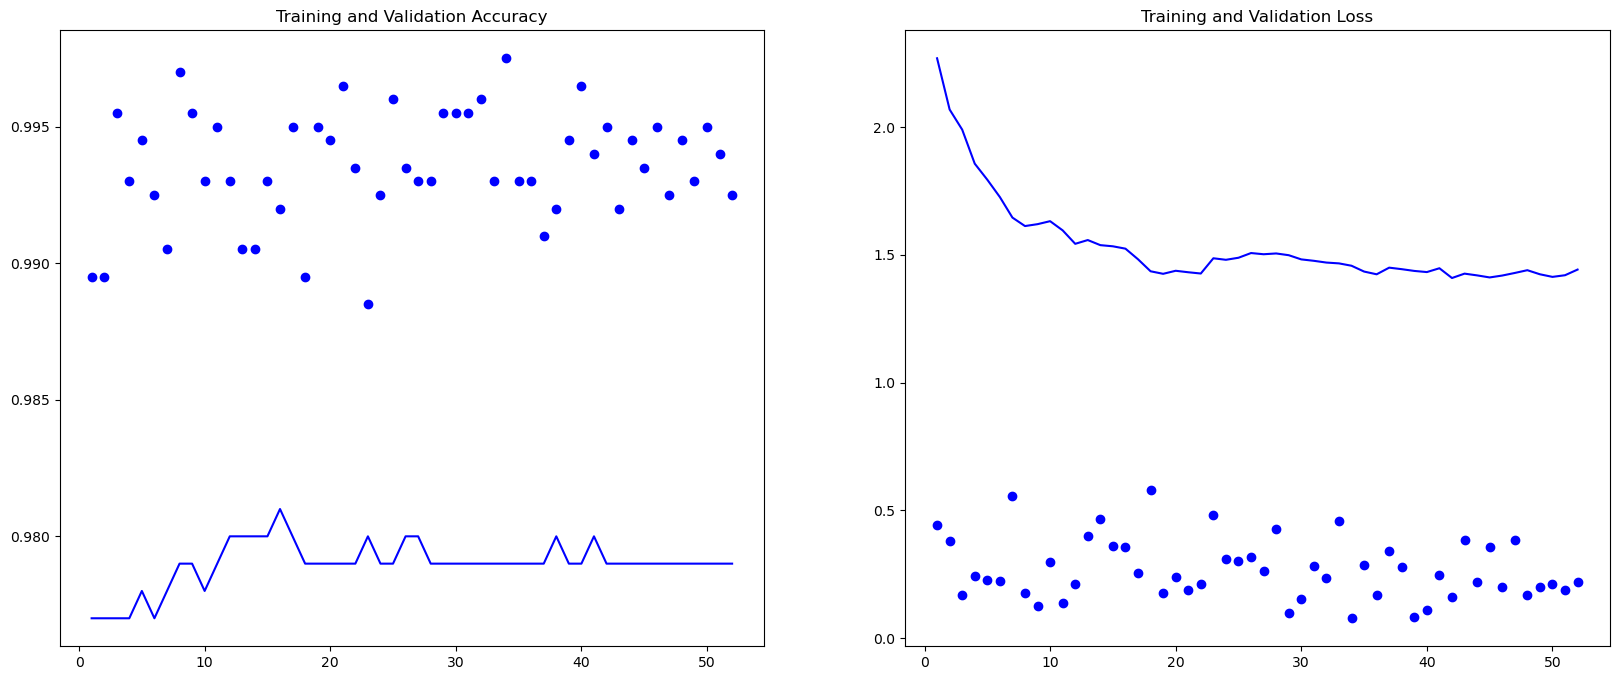

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

ax[0].plot(epochs, accuracy, 'bo', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')

ax[0].set_title('Training and Validation Accuracy')
# plt.legend(), plt.figure();

ax[1].plot(epochs, loss, 'bo', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
# plt.legend(), plt.figure();

In [24]:
ft_te_model = keras.models.load_model('strategy.keras')

ft_te_loss, ft_te_acc = ft_te_model.evaluate(te_d)

print(f"Fine-tunin test accuracy: {ft_te_acc:.3f}")

2023-04-11 15:00:20.347402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 15:00:20.347704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-04-11 15:00:21.194348: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-11 

63/63 [==============================] - 10s 105ms/step - loss: 2.1353 - accuracy: 0.9785
Fine-tunin test accuracy: 0.979


In [13]:
# Accuracy
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1 )

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[].plot(epochs, accuracy, 'bo', label='Trainin Accuracy')
ax[].plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax[].set_title('Training and Validation Accuracy')
ax.legend(), ax[].figure();

ax[].plot(epochs, loss, 'bo', label='Training Loss')
ax[].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[].set_title('Training and Validation Loss')
ax[].legend(), ax[]
